In [1]:
from pathlib import Path
import cv2
import numpy as np

from ultralytics import YOLO
from ultralytics.utils import yaml_load

In [3]:
!pip install -q sahi

In [3]:
class ObjectDetectionWrapper(object):

    def __init__(self,
                 weights,
                 device,
                 threshold=0.40,
                 iou_threshold=0.45,
                 max_det=100,
                 agnostic_nms=False,
                 imgsz=640,
                 task='detect',
                 use_sahi=False,
                 slice_height=512,
                 slice_width=512,
                 overlap_height_ratio=0.1,
                 overlap_width_ratio=0.1,
                 ):

        self.weights = weights
        self.device = device
        self.prob_threshold = threshold
        self.iou_threshold = iou_threshold
        self.max_det = max_det
        self.agnostic_nms = agnostic_nms
        self.imgsz = imgsz
        self.task = task
        self.use_sahi = use_sahi
        self.slice_height = slice_height
        self.slice_width = slice_width
        self.overlap_height_ratio = overlap_height_ratio
        self.overlap_width_ratio = overlap_width_ratio
        self.get_sliced_prediction = None

        if not self.use_sahi:
            if 'detr' not in self.weights:
                self.model = YOLO(self.weights, task=self.task)
            else:
                self.model = RTDETR(self.weights)

            if self.model.names is None:
                if 'openvino' in self.weights or self.weights.endswith('.onnx'):
                    if 'openvino' in self.weights:
                        metadata = Path(self.weights) / 'metadata.yaml'
                    else:
                        metadata = Path(self.weights.replace('.onnx', '_openvino_model')) / 'metadata.yaml'
                    if isinstance(metadata, (str, Path)) and Path(metadata).exists():
                        metadata = yaml_load(metadata)
                    if metadata and 'names' in metadata.keys():
                        self.classes = metadata['names']
                else:
                    self.classes = {0: 'None'}
            else:
                self.classes = self.model.names

        else:
            from sahi import AutoDetectionModel
            from sahi.predict import get_sliced_prediction
            self.get_sliced_prediction = get_sliced_prediction

            if not self.weights.endswith('.pt'):
                raise ValueError(f'Use torch model instead of {self.weights}')

            self.model = AutoDetectionModel.from_pretrained(
                model_type='yolov8',
                model_path=self.weights,
                confidence_threshold=self.prob_threshold,
                device=self.device,
            )
            self.classes = self.model.model.names

        self.model_args = {
            'conf': self.prob_threshold,
            'iou': self.iou_threshold,
            'agnostic_nms': self.agnostic_nms,
            'max_det': self.max_det,
            'imgsz': self.imgsz,
            'verbose': False,
            'device': self.device,
        }

    def detect(self, image):

        if not self.use_sahi:

            results = self.model.predict(image, **self.model_args)
            results = results[0].cpu().numpy()
            if results:
                boxes_xy = results.boxes.xyxy.astype(int)
                boxes_scores = results.boxes.conf.astype(float)
                boxes_classes = results.boxes.cls

                masks = results.masks
                if masks is not None:
                    return (boxes_xy, masks.data), boxes_scores, boxes_classes

                keypoints = results.keypoints
                if keypoints is not None:
                    keypoints_xy = keypoints.xy.astype(int)
                    keypoints_scores = keypoints.conf.astype(float)
                    return (boxes_xy, keypoints_xy, keypoints_scores), boxes_scores, boxes_classes

                return boxes_xy, boxes_scores, boxes_classes

            return np.array([]), np.array([]), np.array([])

        else:
            if self.slice_height > image.shape[0] or self.slice_width > image.shape[1]:
                raise ValueError(f'Incorrect slice_height/slice_width {self.slice_height}/{self.slice_width} '
                                 f'for shape {image.shape[:2]}')
            results = self.get_sliced_prediction(
                image[:, :, ::-1],
                self.model,
                slice_height=self.slice_height,
                slice_width=self.slice_width,
                overlap_height_ratio=self.overlap_height_ratio,
                overlap_width_ratio=self.overlap_width_ratio,
                postprocess_match_threshold=self.model_args['iou'],
                postprocess_class_agnostic=self.model_args['agnostic_nms'],
            )

            if results.object_prediction_list:

                boxes_xy, boxes_scores, boxes_classes = [], [], []
                for result in results.object_prediction_list:
                    boxes_xy.append(result.bbox.to_xyxy())
                    boxes_scores.append(result.score.value)
                    boxes_classes.append(result.category.id)

                boxes_xy = np.array(boxes_xy, dtype=int)
                boxes_scores = np.array(boxes_scores)
                boxes_classes = np.array(boxes_classes, dtype=int)

                return boxes_xy, boxes_scores, boxes_classes

            return np.array([]), np.array([]), np.array([])

# Пример использования
detector = ObjectDetectionWrapper(
    weights='/Users/user/virtualenv/rosatom/best_yolov8_100_80_20.pt',
    device='cuda:0',
    threshold=0.40,
    iou_threshold=0.45,
    max_det=100,
    agnostic_nms=False,
    imgsz=640,
    task='detect',
    use_sahi=True,
    slice_height=512,
    slice_width=512,
    overlap_height_ratio=0.1,
    overlap_width_ratio=0.1,
)

image = cv2.imread('/Users/user/virtualenv/rosatom/pascal_voc_rosatom/JPEGImages/1_1_.jpg')
boxes, scores, classes = detector.detect(image)
print("Boxes:", boxes)
print("Scores:", scores)
print("Classes:", classes)

Performing prediction on 15 slices.
Boxes: [[ 717  118  779  200]
 [ 767 1029  808 1067]
 [1118  880 1149  931]
 [ 720   44  755   74]
 [1508  274 1562  398]
 [ 523   92  580  136]
 [ 789  315  827  365]
 [1145  577 1176  614]
 [ 103  276  131  310]
 [ 411    0  448   24]
 [ 803  139  831  164]
 [ 748  649  767  671]
 [  76   34  131   93]
 [ 120  138  180  184]
 [1118  543 1150  586]
 [ 674   39  696   69]
 [ 894  980 1090 1029]]
Scores: [    0.78233     0.72119     0.71865       0.638     0.63739     0.63217      0.6227     0.61377     0.50943     0.49748     0.49228      0.4552     0.45258     0.44615      0.4207     0.41787     0.62989]
Classes: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2]


Performing prediction on 15 slices.


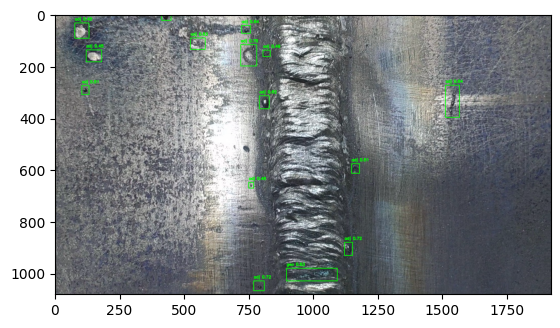

Saved annotated image to /Users/user/virtualenv/rosatom/1_1_with_sahi.jpg


In [20]:
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# Пример использования
detector = ObjectDetectionWrapper(
    weights='/Users/user/virtualenv/rosatom/best_yolov8_100_80_20.pt',
    device='cuda:0',
    threshold=0.44,
    iou_threshold=0.45,
    max_det=100,
    agnostic_nms=False,
    imgsz=640,
    task='detect',
    use_sahi=True,
    slice_height=512,
    slice_width=512,
    overlap_height_ratio=0.1,
    overlap_width_ratio=0.1,
)

image_path = '/Users/user/virtualenv/rosatom/data_to_train/JPEGImages/1_1_.jpg'
image = cv2.imread(image_path)
boxes, scores, classes = detector.detect(image)

# Рисуем боксы на изображении
for box, score, cls in zip(boxes, scores, classes):
    if len(box) == 4:  # Пропускаем, если нет обнаруженных объектов
        x1, y1, x2, y2 = box
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Рисуем зелёный прямоугольник
        cv2.putText(image, f'{detector.classes[cls]} {score:.2f}', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Отображаем и сохраняем финальную картинку
plt.imshow(image)
plt.show()

# Сохраняем результаты
output_image_path = f'/Users/user/virtualenv/rosatom/1_1_with_sahi.jpg'
cv2.imwrite(output_image_path, image)
print(f"Saved annotated image to {output_image_path}")


Saved annotated image to /Users/user/virtualenv/rosatom/1_1_without_sahi.jpg


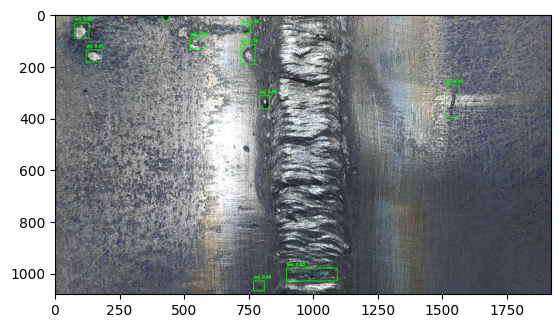

Without SaHI:
Boxes: [[ 717  118  772  193]
 [1508  274 1562  398]
 [ 523   92  580  136]
 [ 894  980 1090 1029]
 [ 789  315  827  365]
 [ 413    0  443   24]
 [ 720   44  755   74]
 [ 767 1029  808 1067]
 [  76   34  131   93]
 [ 120  138  180  184]]
Scores: [    0.78233     0.63739     0.63217     0.62989      0.6227     0.49748     0.45932     0.45837     0.45258     0.44615]
Classes: [          0           0           0           2           0           0           0           0           0           0]


In [17]:
# Пример использования без SaHI
detector_without_sahi = ObjectDetectionWrapper(
    weights='/Users/user/virtualenv/rosatom/best_yolov8_100_80_20.pt',
    device='cpu',
    threshold=0.40,
    iou_threshold=0.45,
    max_det=100,
    agnostic_nms=False,
    imgsz=640,
    task='detect',
    use_sahi=False,  # Указываем использовать модель без SaHI
)

# Пример изображения для обработки
image_path = '/Users/user/virtualenv/rosatom/data_to_train/JPEGImages/1_1_.jpg'
image = cv2.imread(image_path)

# Получаем предсказания от модели без SaHI
boxes_without_sahi, scores_without_sahi, classes_without_sahi = detector_without_sahi.detect(image)
# Рисуем боксы на изображении
for box, score, cls in zip(boxes_without_sahi, scores_without_sahi, classes_without_sahi):
    if len(box) == 4:  # Пропускаем, если нет обнаруженных объектов
        x1, y1, x2, y2 = box
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Рисуем зелёный прямоугольник
        cv2.putText(image, f'{detector.classes[cls]} {score:.2f}', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        
output_image_path = f'/Users/user/virtualenv/rosatom/1_1_without_sahi.jpg'
cv2.imwrite(output_image_path, image)
print(f"Saved annotated image to {output_image_path}")

# Отображаем и сохраняем финальную картинку
plt.imshow(image)
plt.show()
# Выводим результаты
print("Without SaHI:")
print("Boxes:", boxes_without_sahi)
print("Scores:", scores_without_sahi)
print("Classes:", classes_without_sahi)


In [5]:
import cv2
import numpy as np
import os
import csv
from pathlib import Path
import re

# Предполагаем, что класс ObjectDetectionWrapper определен здесь

detector_without_sahi = ObjectDetectionWrapper(
    weights='/Users/user/virtualenv/rosatom/best_yolov8_100_80_20.pt',
    device='cpu',  # Используем CPU
    threshold=0.6,
    iou_threshold=0.45,
    max_det=100,
    agnostic_nms=False,
    imgsz=640,
    task='detect',
    use_sahi=False,  # Используем модель без SaHI
)

input_folder = '/Users/user/virtualenv/rosatom/dataset'
output_folder = '/Users/user/virtualenv/rosatom/annotated_images'
csv_filename = '/Users/user/virtualenv/rosatom/submission_8l_100_90_10.csv'

# Создаем выходную папку, если её нет
os.makedirs(output_folder, exist_ok=True)

# Функция для извлечения чисел из имени файла
def extract_number(filename):
    # Извлекаем все числа из имени файла
    numbers = re.findall(r'\d+', filename)
    # Преобразуем их в целые числа и возвращаем в виде кортежа
    return tuple(map(int, numbers))

# Получаем список всех файлов в папке и сортируем их по числам в имени
files = sorted(os.listdir(input_folder), key=extract_number)

# Временный список для хранения результатов
results = []

# Обрабатываем изображения из отсортированного списка файлов
for image_name in files:
    if image_name.lower().endswith('.jpg'):
        image_path = os.path.join(input_folder, image_name)
        image = cv2.imread(image_path)

        # Получаем предсказания от модели без SaHI
        boxes_without_sahi, scores_without_sahi, classes_without_sahi = detector_without_sahi.detect(image)

        # Рисуем боксы на изображении и сохраняем результаты в список
        for box, score, cls in zip(boxes_without_sahi, scores_without_sahi, classes_without_sahi):
            if len(box) == 4:  # Пропускаем, если нет обнаруженных объектов
                x1, y1, x2, y2 = box
                cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Рисуем зелёный прямоугольник
                cv2.putText(image, f'{cls} {score:.2f}', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

                # Рассчитываем относительные координаты и размеры
                rel_x = (x1 + x2) / 2 / image.shape[1]
                rel_y = (y1 + y2) / 2 / image.shape[0]
                width = (x2 - x1) / image.shape[1]
                height = (y2 - y1) / image.shape[0]

                # Добавляем результат в список
                results.append({
                    'filename': image_name,
                    'class_id': cls,
                    'rel_x': rel_x,
                    'rel_y': rel_y,
                    'width': width,
                    'height': height
                })

        # Сохраняем аннотированное изображение
        output_image_path = os.path.join(output_folder, f'{Path(image_name).stem}_without_sahi.jpg')
        cv2.imwrite(output_image_path, image)
        print(f"Saved annotated image to {output_image_path}")

# Сортируем результаты по имени файла
sorted_results = sorted(results, key=lambda x: extract_number(x['filename']))

# Записываем отсортированные данные в CSV файл
with open(csv_filename, 'w', newline='') as csvfile:
    fieldnames = ['filename', 'class_id', 'rel_x', 'rel_y', 'width', 'height']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames, delimiter=';')
    writer.writeheader()
    for row in sorted_results:
        writer.writerow(row)

print(f"CSV file sorted and saved to {csv_filename}")


Saved annotated image to /Users/user/virtualenv/rosatom/annotated_images/1 (1)_without_sahi.jpg
Saved annotated image to /Users/user/virtualenv/rosatom/annotated_images/1 (2)_without_sahi.jpg
Saved annotated image to /Users/user/virtualenv/rosatom/annotated_images/1 (3)_without_sahi.jpg
Saved annotated image to /Users/user/virtualenv/rosatom/annotated_images/1 (4)_without_sahi.jpg
Saved annotated image to /Users/user/virtualenv/rosatom/annotated_images/1 (5)_without_sahi.jpg
Saved annotated image to /Users/user/virtualenv/rosatom/annotated_images/1 (6)_without_sahi.jpg
Saved annotated image to /Users/user/virtualenv/rosatom/annotated_images/1 (7)_without_sahi.jpg
Saved annotated image to /Users/user/virtualenv/rosatom/annotated_images/1 (8)_without_sahi.jpg
Saved annotated image to /Users/user/virtualenv/rosatom/annotated_images/1 (9)_without_sahi.jpg
Saved annotated image to /Users/user/virtualenv/rosatom/annotated_images/1 (10)_without_sahi.jpg
Saved annotated image to /Users/user/vi

KeyboardInterrupt: 

## Округление

In [27]:
import pandas as pd

# Пути к файлам
input_csv = '/Users/user/virtualenv/rosatom/submission_8s_150_90_10_int.csv'  # Исходный файл
output_csv = '/Users/user/virtualenv/rosatom/submission_8s_150_90_10_rounded.csv'  # Выходной файл

# Чтение CSV файла с разделителем `;`
df = pd.read_csv(input_csv, delimiter=';')

# Округление значений в столбцах `rel_x`, `rel_y`, `width` и `height` до 10 знаков после запятой
df['rel_x'] = df['rel_x'].round(10)
df['rel_y'] = df['rel_y'].round(10)
df['width'] = df['width'].round(10)
df['height'] = df['height'].round(10)

# Запись изменённых данных в новый CSV файл с разделителем `;`
df.to_csv(output_csv, index=False, sep=';')

print(f"CSV file with rounded values saved to {output_csv}")


CSV file with rounded values saved to /Users/user/virtualenv/rosatom/submission_8s_150_90_10_rounded.csv
